# Clustering of Trajectories under Global Confounding

In [1]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"
#optimal transport library
#import ot

#exotic clustering algorithm, TDA
#from tomaster import tomato
#from gudhi.clustering.tomato import Tomato

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

#backtester
#import bt

#machine learning library for time series
#import tslearn
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime

#import pyvinecopulib as pv

import os
import warnings
warnings.filterwarnings("ignore")

#import tensorflow as tf
#import tensorflow.experimental.numpy as tnp
#tnp.experimental_enable_numpy_behavior()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

from helpers import *
import copy

%matplotlib inline
plt.style.use('matplotlibrc')

In [2]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 100 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.1, small=False, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [3]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        #dataset = confound_mdp.collect_sample(int(100000), mdp, pi_b, horizon, iid=False)
        dataset = getSamplesMultiProc(10000, mdp, pi_b, horizon, iid=False)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        '''
        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = []

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, R_sa, data, mdp)
            fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])
            
        '''

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 100
value of pi_b
-4.228685955734954


In [4]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
@njit(cache=True)
def getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P):
    prob = np.zeros((nStates, nStates, nActions))
    for sp in range(nStates):
        for s in range(nStates):
            for a in range(nActions):
                for u in range(len(u_dist)):
                    prob[sp, s, a] += u_dist[u] * pi_b[u, s, a] * (1/pi_bsa[s,a]) * P[u, a, s, sp]
    return prob
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [39]:
# x, a, u, x', r
dataset.shape

(10000, 100, 5)

In [5]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

#from sklearn.decomposition import PCA
#pca = PCA(n_components=10, whiten=False).fit_transform(X)

In [6]:
#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
#threes = dataset #comment for non-sanity check
print(threes.shape)
stateactions = threes[:,:,0] + threes[:,:,1]*nStates #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
confounders = threes[:,:,2]
labels = confounders[:,0]
nextstates = threes[:,:,3]

L = 2
S = nStates*nActions
N = len(threes)

(999998, 3, 5)
(999998, 3, 5)


In [7]:
middles = stateactions[stateactions[:,1].argsort()]
groupedSA = np.split(middles, np.unique(middles[:, 1], return_index=True)[1][1:])

from numba import prange
@njit(parallel=False)
def getOj(group, S = S, N = N):
    Oj = np.zeros((S, S))
    for idx in prange(len(group)):
        i, j, k = group[idx]
        Oj[int(i), int(k)] += 1
    Oj /= N
    return Oj
Ojs = [getOj(group) for group in groupedSA]
len(Ojs)

In [8]:
@njit(parallel=False, cache=True)
def getOj(stateactions, S = S):
    Ojs = np.zeros((S, S, S))
    for idx in range(len(stateactions)):
        i,j,k = stateactions[idx]
        Ojs[int(i), int(j), int(k)] += 1
    return Ojs / len(stateactions)
Ojs = [getOj(stateactions)[:,j,:] for j in range(S)]

In [9]:
@njit(parallel=False, cache=True)
def getMlij_true(P, pi_b, u_dist, nStates, nActions):
    Mlij_true = np.zeros((len(u_dist), nStates*nActions, nStates*nActions))
    for u in range(P.shape[0]):
        for s in range(P.shape[2]):
            for a in range(P.shape[1]):
                for sp in range(P.shape[3]):
                    for ap in range(nActions):
                        Mlij_true[u, int(s+a*nStates), int(sp+ap*nStates)] = P[u,a,s,sp] * pi_b[u, sp, ap]
    return Mlij_true
Mlij_true = getMlij_true(P, pi_b, u_dist, nStates, nActions)

In [10]:
@njit(parallel=False, cache=True)
def getOjs_true(P, pi_b, Mlij_true, u_dist, nStates, nActions):
    slj = np.zeros((len(u_dist), nStates*nActions))
    for u in range(slj.shape[0]):
        for s in range(nStates):
            for a in range(nActions):
                slj[u, int(s+a*nStates)] = np.mean(x_dist) * pi_b[u, s, a]
                
    Ojs_true = np.zeros((nStates*nActions, nStates*nActions, nStates*nActions)) #j, i, k
    for j in range(nStates*nActions):
        for u in range(len(u_dist)):
            for i in range(nStates*nActions):
                for k in range(nStates*nActions):
                    Ojs_true[j, i, k] += slj[u, i] * Mlij_true[u, i, j] * Mlij_true[u, j, k]
    return Ojs_true
Ojs_true = getOjs_true(P, pi_b, Mlij_true, u_dist, nStates, nActions)

In [29]:
np.max(np.abs(Ojs_true - np.array(Ojs)))

0.027145608017076623

In [ ]:
#Ojs = [Ojs_true[j,:,:] for j in range(nStates*nActions)]

In [11]:
N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in data:
    N_sa[int(s),int(a)] += 1

[8.12027593e-05 1.29318059e-05 7.66486157e-06 4.47534349e-06
 3.49538910e-06]


(2, 256)

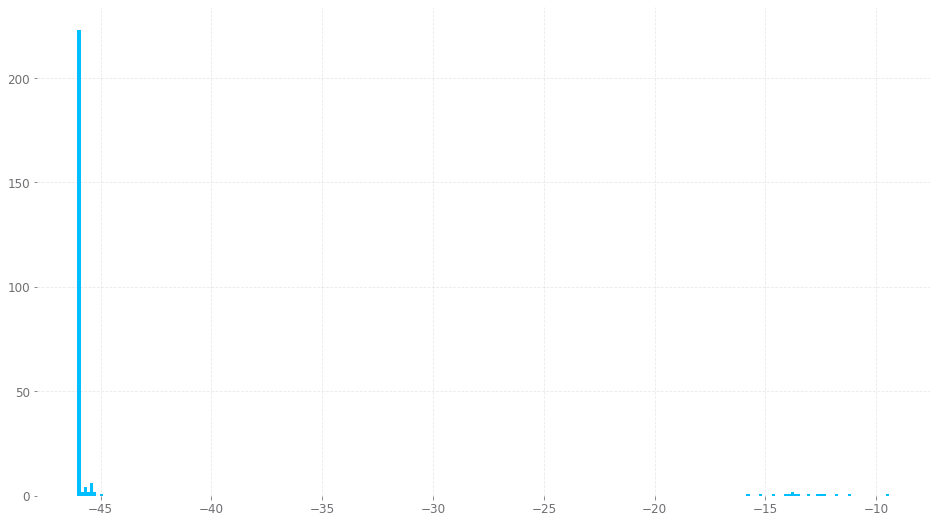

In [12]:
def getPjpQjp(Ojs, L=L):
    Pjps = []
    Qjps = []
    for idx, Oj in enumerate(Ojs):
        Ujt, Sigj, Vj = scipy.linalg.svd(Oj, full_matrices=False, lapack_driver='gesvd') #np returns U S V.T = U.T S V for us
        if idx == (5):
            plt.figure(figsize=(16,9))
            plt.hist(np.log(Sigj+1e-20), bins=len(Sigj))
            print(Sigj[:5])
        #print(np.sort(Sigj)[::-1])
        Ujt = Ujt[:,:L]
        Sigj = Sigj[:L]
        Vj = Vj[:L,:]
        Pjprime = Ujt.T # = Uj
        Qjprime = np.diag(Sigj) @ Vj
        Pjps.append(Pjprime)
        Qjps.append(Qjprime)
    return Pjps, Qjps

Pjps, Qjps = getPjpQjp(Ojs)    
Qjps[5].shape

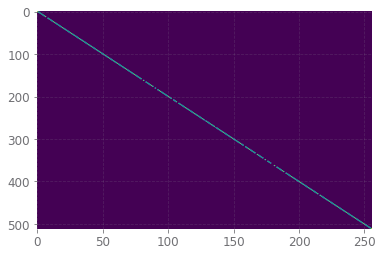

In [13]:
#step 2: cokernel
#the ith block of the jth blockdiag matrix is the jth column of -Qi
#the third block of the 2nd matrix is the 2nd column of -Q3
def getblockdiag(j, Qjps):
    return scipy.linalg.block_diag(*[-Qjps[i][:,j][:,None] for i in range(S)])
    
plt.imshow(getblockdiag(4, Qjps) != 0, aspect='auto')
Apprime = scipy.linalg.block_diag(*Pjps)
Aqprime = np.hstack([getblockdiag(j, Qjps) for j in range(S)])
Apqprime = np.vstack([Apprime, Aqprime])

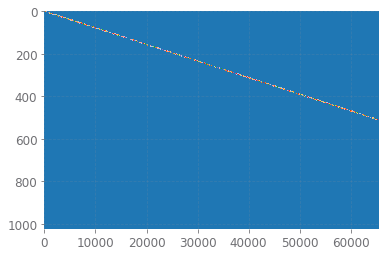

In [14]:
plt.imshow(Apqprime != 0, aspect='auto', cmap='tab20')

In [ ]:
#cokerprime = scipy.linalg.null_space(Apqprime.T, rcond=0.9e-5).T #.shape , rcond=1.5e-5
#, rcond=1.1e-5
#cokerprime.shape

In [15]:
_, _, cokerprime = scipy.sparse.linalg.svds(Apqprime.T, k=L, which='SM', solver='lobpcg')

In [16]:
Yprimes = cokerprime[:,:L*S]
Zprimes = cokerprime[:,L*S:]
#check to see if reshape equivalent
print(sum([Yprimes[:,L*test:L*test+L] - Yprimes.reshape(L, S, L).transpose(1, 0, 2)[test] for test in range(S)]))
Yprimes = Yprimes.reshape(L, S, L).transpose(1, 0, 2)
Zprimes = Zprimes.reshape(L, S, L).transpose(1, 0, 2)

[[0. 0.]
 [0. 0.]]


In [17]:
#step 3: diagonalization
ZpYpT = [Zprimes[j] @ Yprimes[j].T for j in range(S)]
todiag = np.sum([np.linalg.pinv(ZpYpT[j]) @ ZpYpT[j+1] for j in range(S - 1)], axis=0)
Rprime = np.linalg.eigh(todiag + todiag.T)[1].T
Rprime

array([[-0.9916299 ,  0.12911293],
       [-0.12911293, -0.9916299 ]])

In [18]:
#step 4: two-trail matching
# fix \Pi to be the identity permutation
#np.diag((Ojs[0] @ np.ones(S)) @ np.linalg.pinv(Rprime @ Yprimes[0] @ Pjps[0]))
D = np.mean([np.diag((Ojs[j] @ np.ones(S)).T @ np.linalg.pinv(Rprime @ Yprimes[j] @ Pjps[j])) for j in range(S-1)], axis=0)
R = D @ Rprime
Yjs = [R @ Yprimes[j] for j in range(S)]
Pjs = [Yjs[j] @ Pjps[j] for j in range(S)]
Sjs = [np.diag(R @ ZpYpT[j] @ R.T) for j in range(S)]
#Sjs
Pjs[0].shape

(2, 256)

In [19]:
Sil = np.abs(np.array(Sjs))
@njit(parallel=False, cache=True)
def getMlij(Sil, Pjs, S=S):
    Mlij = np.zeros((L, S, S))
    for l in range(L):
        for i in range(S):
            for j in range(S):
                Mlij[l, i, j] = Pjs[j, l, i] / Sil[i,l]
    Mlij = np.abs(Mlij)
    for l in range(L):
        for i in range(S):
            norm = np.sum(Mlij[l,i,:])
            for j in range(S):
                Mlij[l,i,j] = Mlij[l,i,j]/norm
    return Mlij

models = getMlij(Sil, np.array(Pjs))

In [20]:
trajsa = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int)
logprobs = np.log(models[:, trajsa[:,:-1], trajsa[:,1:]]).sum(-1) + np.random.uniform(high=1e-7, size=(L, len(dataset)))
max(np.mean(logprobs.argmax(0) == dataset[:,0,2]), np.mean(logprobs.argmax(0) != dataset[:,0,2]))

0.541

In [103]:
models.shape

(2, 256, 256)

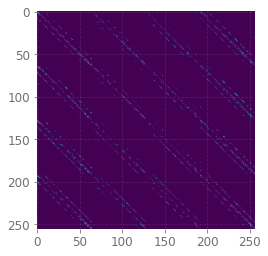

In [115]:
plt.imshow(np.abs(Mlij_true - getMlij(Sil, np.array(Pjs)))[0])

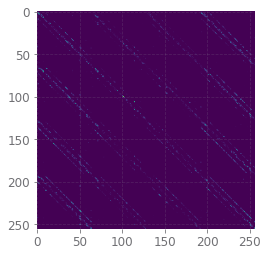

In [116]:
plt.imshow(np.abs(getMlij(Sil, np.array(Pjs))[0] - getMlij(Sil, np.array(Pjs))[1]))

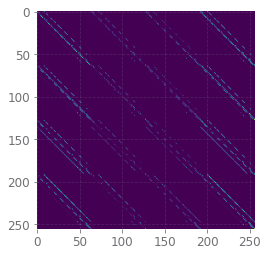

In [117]:
plt.imshow(Mlij_true[1])

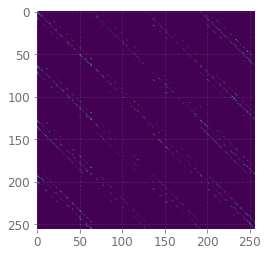

In [118]:
plt.imshow(getMlij(Sil, np.array(Pjs))[1])